In [95]:
from __future__ import division
from collections import defaultdict
import scipy
import numpy as np
import pickle
import itertools
from dist_rsa.dbm import *
from dist_rsa.utils.load_data import *
from dist_rsa.utils.helperfunctions import *
from dist_rsa.utils.config import abstract_threshold,concrete_threshold
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import tensorflow as tf

# vec_size,vec_kind = 25,'glove.twitter.27B.'
vec_size,vec_kind = 300,'glove.6B.'
# freqs = pickle.load(open('dist_rsa/data/google_freqs/freqs','rb'))
nouns,adjs = get_words(with_freqs=False)
vecs = load_vecs(mean=True,pca=False,vec_length=vec_size,vec_type=vec_kind) 

def l1_model(subj,pred):

    print('abstract_threshold',abstract_threshold)
    print('concrete_threshold',concrete_threshold)

    qud_words = [a for a in list(adjs) if adjs[a] < abstract_threshold and a in vecs]

    quds = sorted(qud_words,\
        key=lambda x:scipy.spatial.distance.cosine(vecs[x],np.mean([vecs[pred],vecs[pred]],axis=0)),reverse=False)
        # key=lambda x:freqs[x],reverse=True)

    noun_words = [n for n in nouns if nouns[n] > concrete_threshold and n in vecs]
    possible_utterances = sorted(noun_words,\
        key=lambda x: scipy.spatial.distance.cosine(vecs[x],np.mean([vecs[subj],vecs[subj]],axis=0)),reverse=False)
        # key=lambda x:freqs[x],reverse=True)


    for x in possible_utterances:
        if x not in vecs:
            # print(x,"not in vecs")
            possible_utterances.remove(x)
            # raise Exception("utterance not in vecs")

    quds = quds[:30]
    possible_utterances = possible_utterances[:1000]

    print("QUDS",quds[:10]) 
    print("UTTERANCES:\n",possible_utterances[:10])


    params = Inference_Params(
        vecs=vecs,
        subject=[subj],predicate=pred,
        quds=quds,
        possible_utterances=list(set(possible_utterances).union(set([pred]))),
        sig1=10.0,sig2=1.0,l1_sig1=10.0,
        qud_weight=0.0,freq_weight=0.0,
        number_of_qud_dimensions=1,
        poss_utt_frequencies=defaultdict(lambda:1),
        qud_frequencies=defaultdict(lambda:1),
        rationality=1.0,
        norm_vectors=False,
        heatmap=False,
        resolution=Resolution(span=10,number=100),
        model_type="discrete_mixture",
        )

    run = Dist_RSA_Inference(params)
    run.compute_l1(load=0,save=False)


    out = run.tf_results
    tf.reset_default_graph()
    return out,params

    # world_means = run.world_samples
    # print(world_means[:5],"MEANS")

    # print(results[:5])

    # if not is_baseline:
    #     worldm = run.world_movement("cosine",comparanda=[x for x in qud_words if x in vecs])
    #     # print("\nworld\n",worldm[:5])
    # else: worldm = None
        # out.write("\nWORLD MOVEMENT:\n")
        # out.write(str(worldm))
    # print("WORLD MOVEMENT WITH PROJECTION\n:",run.world_movement("cosine",comparanda=[x for x in quds if x in vecs],do_projection=True)[:50])
    # print("BASELINE:\n",sorted(qud_words,\
    #     key=lambda x:scipy.spatial.distance.cosine(vecs[x],np.mean([vecs[subj],vecs[pred]],axis=0)),reverse=False)[:5])

    # demarg = demarginalize_product_space(results)
    # print("\ndemarginalized:\n,",demarg[:5])
    # out.write("\ndemarginalized:\n")
    # out.write((str(demarg)))

    # params.number_of_qud_dimensions=1
    # run = Dist_RSA_Inference(params)
    # run.compute_l1(load=0,save=False)
    # results2 = run.qud_results()
    # # print("\n1d results\n",results2[:10])
    # one_d = results2
    # one_d=None

if __name__ == "__main__":

    

    # for x in range(1):
    #     l1_model(("father","shark",0.5,0.5,1.0,0,100,False))
    subj,pred = "man","shark"
    result,params = l1_model(subj=subj,pred=pred)


        # print()


        # print(l1_model(subj="man",pred="swimmer"))

        # print(scipy.spatial.distance.cosine(vecs['man']-means1[0],vecs['man']-means2[0]))
        # worlds,quds=l1_model(("wall","frog",1.0,1.0,1.0,0,1000,True))
        # print(quds[:10])






loading vecs (load vecs): glove.6B.mean_vecs300
abstract_threshold 2.5
concrete_threshold 3.0


  0%|          | 0/30 [00:00<?, ?it/s]

QUDS ['wild', 'rare', 'similar', 'latest', 'prized', 'good', 'famous', 'great', 'mysterious', 'other']
UTTERANCES:
 ['man', 'woman', 'person', 'boy', 'men', 'father', 'girl', 'guy', 'hand', 'brother']
RESOLUTION. SIZE: 100 AMOUNT: 0.1
subject: ['man']
predicate shark
SIGs 1&2: 10.0 1.0
L1 SIG 10.0
number of qud dimensions: 1
rationality: 1.0
Running discrete_mixture RSA with 1000 possible utterances and 30
RUNNING DISCRETE MIXTURE MODEL
qud_combinations 30 [['bad'], ['best'], ['common'], ['dangerous'], ['exotic'], ['famous'], ['good'], ['great'], ['latest'], ['likely'], ['lone'], ['mega'], ['mysterious'], ['natural'], ['occasional'], ['other'], ['particular'], ['prized'], ['rare'], ['similar'], ['spectacular'], ['strange'], ['supposed'], ['true'], ['typical'], ['uncommon'], ['unusual'], ['usual'], ['vulnerable'], ['wild']]
quds 30
SIZE,AMOUNT 100 0.1


100%|██████████| 30/30 [02:22<00:00,  4.74s/it]


time: 142.18440580368042
time: 38.018354177474976
(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.3290808]] [[8.480037]]
0 0 2.3290808 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.2691221]] [[8.275655]]
0 1 3.2691221 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.598563]] [[8.728909]]
0 2 2.598563 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.7142646]] [[8.562244]]
0 3 2.7142646 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[1.7955616]] [[7.799782]]
0 4 1.7955616 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.2109768]] [[8.719313]]
0 5 3.2109768 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.37283]] [[8.427352]]
0 6 3.37283 THING THING

(300, 1)
(300, 1)
(300, 3

mean and variance [[3.7046895]] [[8.658133]]
2 23 3.7046895 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.1077876]] [[8.737119]]
2 24 3.1077876 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.3129852]] [[8.769667]]
2 25 2.3129852 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.2083461]] [[8.581632]]
2 26 3.2083461 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.0062966]] [[8.706177]]
2 27 3.0062966 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.4448838]] [[8.960772]]
2 28 2.4448838 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.767578]] [[2.353383]]
2 29 2.767578 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.379619]] [[8.506816]]
3 0 3.379619 THING T

5 19 3.0112345 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.0810637]] [[8.790351]]
5 20 2.0810637 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.2124705]] [[8.461407]]
5 21 3.2124705 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.4101076]] [[8.875548]]
5 22 3.4101076 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.4260323]] [[8.695547]]
5 23 3.4260323 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.8884199]] [[8.772331]]
5 24 2.8884199 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.2568197]] [[8.803971]]
5 25 2.2568197 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.941889]] [[8.62118]]
5 26 2.941889 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)

8 15 3.4224288 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.1862218]] [[8.681788]]
8 16 3.1862218 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[1.8627933]] [[9.1813]]
8 17 1.8627933 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.844132]] [[7.967251]]
8 18 2.844132 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.105908]] [[8.631568]]
8 19 3.105908 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.2593296]] [[8.719817]]
8 20 2.2593296 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.34244]] [[8.371693]]
8 21 3.34244 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.497931]] [[8.809981]]
8 22 3.497931 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) I

11 11 4.3125296 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[4.7130847]] [[9.239346]]
11 12 4.7130847 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.7163439]] [[8.626036]]
11 13 3.7163439 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.4512239]] [[8.880485]]
11 14 3.4512239 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[4.616606]] [[8.5196085]]
11 15 4.616606 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[4.290178]] [[8.8552065]]
11 16 4.290178 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.4379153]] [[9.289005]]
11 17 2.4379153 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.8071773]] [[8.234672]]
11 18 3.8071773 THING THING

(300, 1)
(300, 1)
(300, 300)

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.8542218]] [[9.018082]]
14 8 3.8542218 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[4.0267224]] [[8.839547]]
14 9 4.0267224 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.9423952]] [[8.825947]]
14 10 3.9423952 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.767128]] [[9.54402]]
14 11 2.767128 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[4.352746]] [[9.252858]]
14 12 4.352746 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.3128269]] [[8.650442]]
14 13 3.3128269 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.3406205]] [[8.900372]]
14 14 3.3406205 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
m

(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[4.2607007]] [[8.589655]]
17 21 4.2607007 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[4.8514037]] [[8.969275]]
17 22 4.8514037 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[5.042856]] [[8.804279]]
17 23 5.042856 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[4.3175354]] [[8.874662]]
17 24 4.3175354 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.7891688]] [[8.903666]]
17 25 3.7891688 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[4.611134]] [[8.73611]]
17 26 4.611134 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[4.1712904]] [[8.847091]]
17 27 4.1712904 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance

mean and variance [[3.2712095]] [[8.5741625]]
21 0 3.2712095 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.7359467]] [[8.382438]]
21 1 3.7359467 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.885144]] [[8.807623]]
21 2 2.885144 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.0255036]] [[8.651279]]
21 3 3.0255036 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[1.6636419]] [[7.9360332]]
21 4 1.6636419 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.4272046]] [[8.798621]]
21 5 3.4272046 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.9808736]] [[8.52474]]
21 6 3.9808736 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.793579]] [[8.439258]]
21 7 3.793579 THING

(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.555685]] [[8.730421]]
23 27 2.555685 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.0863023]] [[8.980245]]
23 28 2.0863023 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.3618512]] [[2.4966698]]
23 29 2.3618512 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.4716356]] [[8.537625]]
24 0 3.4716356 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.7235916]] [[8.340987]]
24 1 3.7235916 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.7644103]] [[8.777068]]
24 2 2.7644103 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.2729266]] [[8.616718]]
24 3 3.2729266 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance

mean and variance [[2.9962292]] [[8.414578]]
26 21 2.9962292 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.4820962]] [[8.841325]]
26 22 3.4820962 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.5282462]] [[8.655846]]
26 23 3.5282462 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.8020597]] [[8.734966]]
26 24 2.8020597 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[1.9727652]] [[8.76757]]
26 25 1.9727652 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.5001822]] [[8.579214]]
26 26 2.5001822 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.7134933]] [[8.703972]]
26 27 2.7134933 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[2.2882664]] [[8.959]]
26 28 2.288266

mean and variance [[4.0951214]] [[8.008278]]
29 18 4.0951214 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[4.374527]] [[8.659187]]
29 19 4.374527 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.3482113]] [[8.745655]]
29 20 3.3482113 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[4.4594946]] [[8.404556]]
29 21 4.4594946 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[4.6208315]] [[8.834]]
29 22 4.6208315 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[4.749628]] [[8.647348]]
29 23 4.749628 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[4.162663]] [[8.726969]]
29 24 4.162663 THING THING

(300, 1)
(300, 1)
(300, 300) (300, 1)
(300,) IMPORTANT SHAPE
mean and variance [[3.3979712]] [[8.759778]]
29 25 3.3979712 THI

In [96]:
result

(None,
 [(['prized'], 'n/a', 0.09796561),
  (['mega'], 'n/a', 0.06303169),
  (['wild'], 'n/a', 0.057306994),
  (['exotic'], 'n/a', 0.051775713),
  (['rare'], 'n/a', 0.045703065),
  (['occasional'], 'n/a', 0.032453854),
  (['spectacular'], 'n/a', 0.031315517),
  (['uncommon'], 'n/a', 0.031147767),
  (['mysterious'], 'n/a', 0.03094501),
  (['vulnerable'], 'n/a', 0.029667033),
  (['particular'], 'n/a', 0.029296359),
  (['lone'], 'n/a', 0.028849203),
  (['supposed'], 'n/a', 0.028093327),
  (['best'], 'n/a', 0.027737236),
  (['other'], 'n/a', 0.027667912),
  (['likely'], 'n/a', 0.02734724),
  (['usual'], 'n/a', 0.026987422),
  (['typical'], 'n/a', 0.026730051),
  (['common'], 'n/a', 0.026450904),
  (['natural'], 'n/a', 0.026110848),
  (['similar'], 'n/a', 0.02609651),
  (['dangerous'], 'n/a', 0.026005877),
  (['unusual'], 'n/a', 0.025980493),
  (['strange'], 'n/a', 0.02559957),
  (['famous'], 'n/a', 0.025534028),
  (['latest'], 'n/a', 0.0253446),
  (['bad'], 'n/a', 0.025104428),
  (['true']

3.3796188831329346


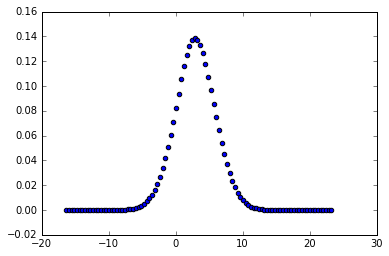

In [98]:
line = 3
qud = 0
vals = params.uncompressed[line][qud]
# vals
print(params.subspace_means[line][qud])
# hm = matplotlib.pyplot.scatter(x=(np.arange(-50,50)*0.4)+params.subspace_prior_means[line][0],y=vals)
vals = params.marginals[line]
hm = matplotlib.pyplot.scatter(x=(np.arange(-50,50)*0.4)+params.subspace_prior_means[line][0],y=vals)

In [ ]:
line = 0
qud = 0
vals = params.uncompressed[line][qud]
# vals
# print(params.subspace_means[line][qud])
# hm = matplotlib.pyplot.scatter(x=(np.arange(-50,50)*0.4)+params.subspace_prior_means[line][0],y=vals)
vals = params.marginals[line]
hm = matplotlib.pyplot.scatter(x=(np.arange(-50,50)*0.4)+params.subspace_prior_means[line][0],y=vals)
# print((np.arange(-50,50)*0.4)+params.subspace_prior_means[line][0])
print(params.subspace_means[line][qud])
print(params.subspace_prior_means[line][qud])

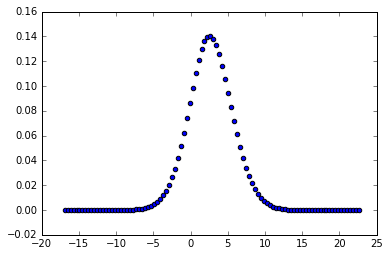

In [70]:
vals = params.marginals[line]
hm = matplotlib.pyplot.scatter(x=(np.arange(-50,50)*0.4)+params.subspace_prior_means[line][0],y=vals)

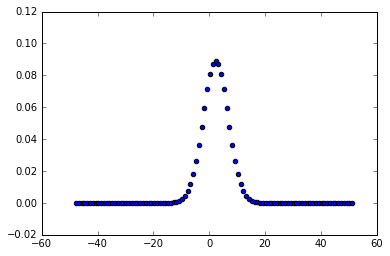

In [39]:
# params.subspace_prior_means.shape
vals = scipy.stats.multivariate_normal.pdf(np.arange(-50,50)+params.subspace_prior_means[3][0],mean=params.subspace_prior_means[3][0],cov=20.0)
hm = matplotlib.pyplot.scatter(x=np.arange(-50,50)+params.subspace_prior_means[3][0],y=vals)


In [131]:
from dist_rsa.utils.simple_vecs import real_vecs as simple_vecs
import itertools




def l1_model(subj,pred,sig1,sig2,l1_sig1,quds,possible_utterances):
    vec_size,vec_kind = 25,'glove.twitter.27B.'

    vecs = simple_vecs
    real_vecs= simple_vecs

    print("UTTERANCES:\n",sorted(list(set(possible_utterances).union(set([pred]))))[:20])

    params = Inference_Params(
        vecs=real_vecs,
        subject=[subj],predicate=pred,
        quds=quds,
        possible_utterances=sorted(list(set(possible_utterances).union(set([pred])))),
        sig1=sig1,sig2=sig2, l1_sig1=l1_sig1,
        qud_weight=0.0,freq_weight=0.0,
        number_of_qud_dimensions=1,
        poss_utt_frequencies=defaultdict(lambda:1),
        qud_frequencies=defaultdict(lambda:1),
        rationality=1.0,
        norm_vectors=False,
        resolution=Resolution(span=10,number=100),
        model_type="discrete_mixture",
        heatmap=False
        )

    run = Dist_RSA_Inference(params)
    run.compute_l1(load=0,save=False)
    tf_results = run.tf_results
    return tf_results,params

if __name__ == "__main__":

    results,params = l1_model(subj="man",pred="swimmer",sig1=20.0,sig2=1.0,l1_sig1=20.0,quds=["vicious","swims"],possible_utterances=["shark","swimmer","man"])


  0%|          | 0/2 [00:00<?, ?it/s]

UTTERANCES:
 ['man', 'shark', 'swimmer']
RESOLUTION. SIZE: 100 AMOUNT: 0.1
subject: ['man']
predicate swimmer
SIGs 1&2: 20.0 1.0
L1 SIG 20.0
number of qud dimensions: 1
rationality: 1.0
Running discrete_mixture RSA with 3 possible utterances and 2
RUNNING DISCRETE MIXTURE MODEL
qud_combinations 2 [['swims'], ['vicious']]
quds 2
SIZE,AMOUNT 100 0.1


100%|██████████| 2/2 [00:07<00:00,  3.61s/it]


time: 7.227520227432251
time: 2.778233051300049
(2, 1)
(2, 1)
(2, 2) (2, 1)
(2,) IMPORTANT SHAPE
mean and variance [[3.004397]] [[20.]]
0 0 3.004397 THING THING

(2, 1)
(2, 1)
(2, 2) (2, 1)
(2,) IMPORTANT SHAPE
mean and variance [[0.]] [[7.5700502]]
0 1 0.0 THING THING

(2, 1)
(2, 1)
(2, 2) (2, 1)
(2,) IMPORTANT SHAPE
mean and variance [[0.]] [[20.]]
1 0 0.0 THING THING

(2, 1)
(2, 1)
(2, 2) (2, 1)
(2,) IMPORTANT SHAPE
mean and variance [[-2.5340216]] [[8.664951]]
1 1 -2.5340216 THING THING

time: 1.3908789157867432


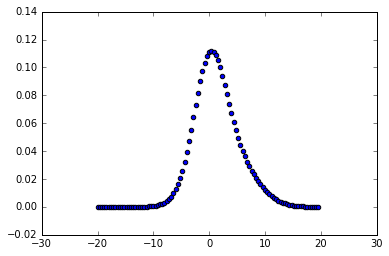

In [140]:
line = 0
qud = 0
# vals = params.uncompressed[line][qud]
# vals
# hm = matplotlib.pyplot.scatter(x=(np.arange(-50,50)*0.4)+params.subspace_prior_means[line][0],y=vals)
vals = params.marginals[line]
hm = matplotlib.pyplot.scatter(x=(np.arange(-50,50)*0.4)+params.subspace_prior_means[line][0],y=vals)

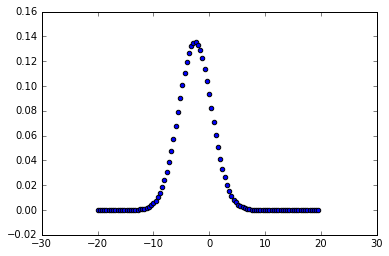

In [137]:
line = 1
qud = 1
vals = params.uncompressed[line][qud]
# vals
# hm = matplotlib.pyplot.scatter(x=(np.arange(-50,50)*0.4)+params.subspace_prior_means[line][0],y=vals)
# vals = params.marginals[line]
hm = matplotlib.pyplot.scatter(x=(np.arange(-50,50)*0.4)+params.subspace_prior_means[line][0],y=vals)

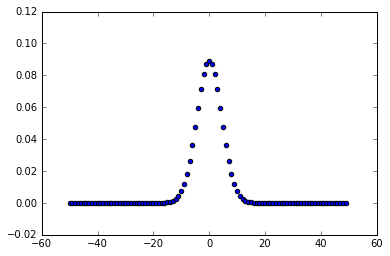

In [138]:
# params.subspace_prior_means.shape
vals = scipy.stats.multivariate_normal.pdf(np.arange(-50,50)+params.subspace_prior_means[line][0],mean=params.subspace_prior_means[line][0],cov=20.0)
hm = matplotlib.pyplot.scatter(x=np.arange(-50,50)+params.subspace_prior_means[line][0],y=vals)


In [142]:
print(params.subspace_prior_means[line][qud])
results

0.0


(None, [(['vicious'], 'n/a', 0.5371483), (['swims'], 'n/a', 0.46285176)])

In [145]:
from dist_rsa.utils.simple_vecs import real_vecs as simple_vecs
import itertools




def l1_model(subj,pred,sig1,sig2,l1_sig1,quds,possible_utterances):
    vec_size,vec_kind = 25,'glove.twitter.27B.'

    vecs = simple_vecs
    real_vecs= simple_vecs

    print("UTTERANCES:\n",sorted(list(set(possible_utterances).union(set([pred]))))[:20])

    params = Inference_Params(
        vecs=real_vecs,
        subject=[subj],predicate=pred,
        quds=quds,
        possible_utterances=sorted(list(set(possible_utterances).union(set([pred])))),
        sig1=sig1,sig2=sig2, l1_sig1=l1_sig1,
        qud_weight=0.0,freq_weight=0.0,
        number_of_qud_dimensions=1,
        poss_utt_frequencies=defaultdict(lambda:1),
        qud_frequencies=defaultdict(lambda:1),
        rationality=1.0,
        norm_vectors=False,
        resolution=Resolution(span=10,number=100),
        model_type="discrete_mixture",
        heatmap=False
        )

    run = Dist_RSA_Inference(params)
    run.compute_l1(load=0,save=False)
    tf_results = run.tf_results
    return tf_results,params

if __name__ == "__main__":

    results,params = l1_model(subj="man",pred="man",sig1=20.0,sig2=1.0,l1_sig1=20.0,quds=["vicious","swims"],possible_utterances=["shark","swimmer","man"])


  0%|          | 0/2 [00:00<?, ?it/s]

UTTERANCES:
 ['man', 'shark', 'swimmer']
RESOLUTION. SIZE: 100 AMOUNT: 0.1
subject: ['man']
predicate man
SIGs 1&2: 20.0 1.0
L1 SIG 20.0
number of qud dimensions: 1
rationality: 1.0
Running discrete_mixture RSA with 3 possible utterances and 2
RUNNING DISCRETE MIXTURE MODEL
qud_combinations 2 [['swims'], ['vicious']]
quds 2
SIZE,AMOUNT 100 0.1


100%|██████████| 2/2 [00:09<00:00,  4.65s/it]


time: 9.306732892990112
time: 3.3718504905700684
(2, 1)
(2, 1)
(2, 2) (2, 1)
(2,) IMPORTANT SHAPE
mean and variance [[-3.2096474]] [[20.]]
0 0 -3.2096474 THING THING

(2, 1)
(2, 1)
(2, 2) (2, 1)
(2,) IMPORTANT SHAPE
mean and variance [[0.]] [[7.246917]]
0 1 0.0 THING THING

(2, 1)
(2, 1)
(2, 2) (2, 1)
(2,) IMPORTANT SHAPE
mean and variance [[0.]] [[20.]]
1 0 0.0 THING THING

(2, 1)
(2, 1)
(2, 2) (2, 1)
(2,) IMPORTANT SHAPE
mean and variance [[-2.5340216]] [[8.664951]]
1 1 -2.5340216 THING THING

time: 1.7726941108703613


In [148]:
results

(None, [(['swims'], 'n/a', 0.61838853), (['vicious'], 'n/a', 0.38161138)])